<a href="https://colab.research.google.com/github/AlisonJD/RTACourse/blob/main/06_Querying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

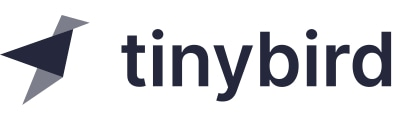
# Principles of Real-Time Analytics Course

In [ ]:
#@title Mount your Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

% cd "/content/gdrive/My Drive/Colab Notebooks/Tinybird"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/Tinybird


In [ ]:
#@title Install Tinybird CLI and token
!pip install tinybird-cli -q -U

import os

if not os.path.isfile('.tinyb'):
  !tb auth

In [ ]:
#@title Helper function
def write_text_to_file(filename, text):
  with open(filename, 'w') as f:
      f.write(text)

In this notebook we use and create these resources:

|Use         | Create     |
| ----------------- |:-------------:|
|taxi.datasource|products_join_sku.datasource|
|events.datasource||
|products.datasource||

# Querying
Everything discussed so far is valuable but not enough to provide real value: only when you turn data into information can you start delivering real value. Here we will connect the dots with all the previous sections.

The key is understanding what happens when you write an SQL query. We are not just talking about understanding an “EXPLAIN ANALYZE” but also all the pragmatic things that you are interested in: understanding joins, denormalization, when to group, when to filter, etc. The concepts covered here are fundamental for your day-to-day work.


## How Analytics Databases Work
The two important things that analytics databases do to improve query times are
1. Parallelization at all levels
 - CPU: use different CPUs to process splitting the load using the map-reduce algorithms
 - Vectorization: use SSE extension to process more than one value at a time 
 - Machines: process data on several machines.
2. Approximate data structures: the best known is [HyperLogLog](https://en.wikipedia.org/wiki/HyperLogLog) that allows you to count the number of different items without using huge amounts of memory.

Analytics databases leverage these two characteristics to be as efficient as possible and do as many tricks as possible during the query planning stage.

Let’s see an example with a simple sum in a setup with several machines:

`SELECT sum(column) FROM table`

1. Send a sum to several machines
2. Each machine will split the table in several chunks and will raise many threads.
3. Every thread will process the sum of several chunks.
4. Inside every thread each core will use SSE instructions to add numbers if possible.
5. Every machine will collect the partial sum processed for every thread and send it to one of them.
6. That last machine sums everything and prints the final number.


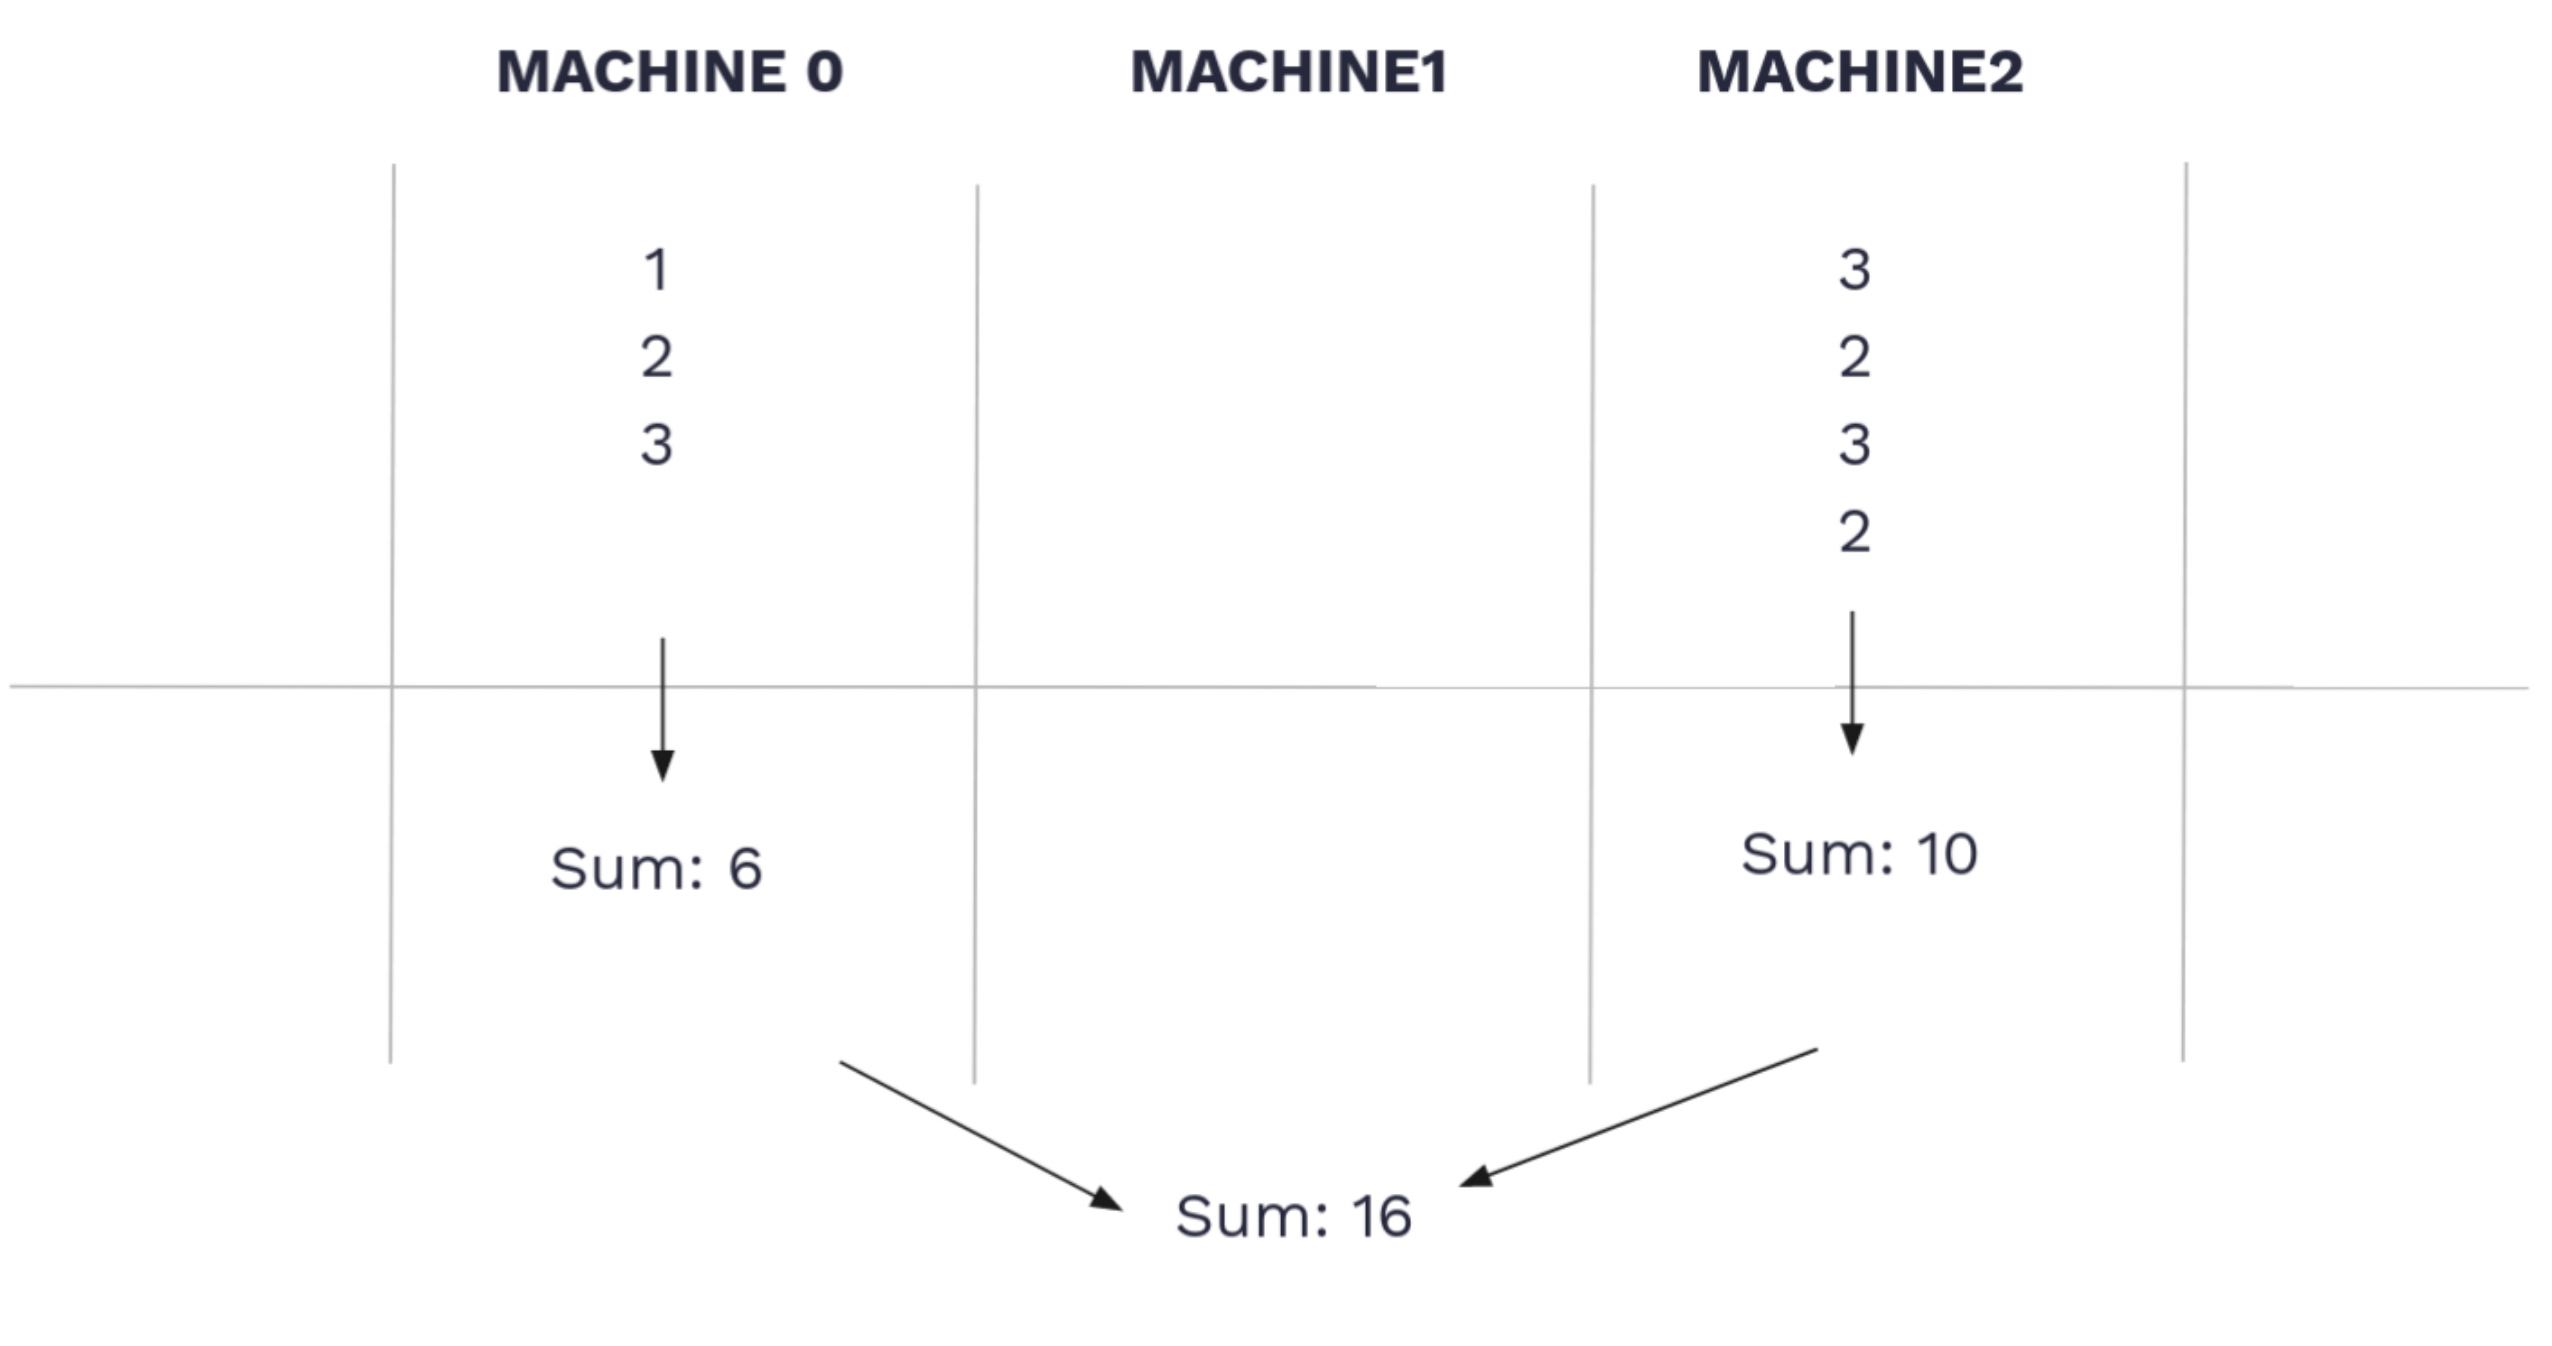

When writing queries in common transactional databases like PostgreSQL, minor errors in queries are not generally a big deal. However, when working with several billion rows, one more single unnecessary operation per row could mean a lot of time.

In the next points, we are going to share some of our techniques and things we take into account to avoid inefficiencies and optimize our query performance.


## Query just the Data you Need
There is no faster query than the one that reads no data. This seems obvious but it’s really important. If you need three columns, just get three columns and use indexes. The less data you read the faster the query will be. This is valid for any database or data system.


## Data Order is Key
Remember that memory speed is faster if you have data in the same area.

If we try to execute a query over a table where the data we want is scattered all over the disk/memory then the computer is going to have a hard time getting all the data: 

- the OS will need to get a lot of pages from the disk into memory. Only part of the data will be useful so you will be reading more data than needed.
- memory , as we know, reaches its maximum throughput when you read data in batches, so you will not be using memory at full capacity.
- CPUs will be waiting for data.

So the key, and we will repeat this over and over again, is to have the data sorted so you get the max from disk, memory and CPU.


## Lightweight and Indexed Operations First (filters, prefilters)
This is also obvious but do leverage the indexes as much as possible. Try to use prefilters if possible when your filters are highly selective. Prefiltering allows you to discard a huge amount of data before fetching the rest of the table. Most databases optimize this by themselves but use it explicitly because they sometimes fail to optimize.


## Understanding Algorithmic Complexity
Not all the queries use the same algorithms. This may seem obvious too but it is very easy to forget.


### Do Less Complex Queries First
Taking algorithmic complexity into account, you should always start doing the less complex operations first in order to reduce the data amount as much as possible as soon as possible because the less data that reaches the complex algorithm, the better.



To understand this, let’s look at a Tinybird example comparing simple aggregation vs group (with different cardinality) vs quantiles on the New York City Taxi Trip dataset.

A simple filter is cheap:

In [ ]:
!tb sql --stats "SELECT sum(trip_distance) FROM taxi WHERE passenger_count = 4"

** Query took 0.041810985 seconds
** Rows read: 84,152,418
** Bytes read: 589.04 MB
----------------------
| sum(trip_distance) |
----------------------
| 5397081.2494365405 |
----------------------


Even cheaper if it uses some indices:

In [ ]:
!tb sql --stats "SELECT sum(trip_distance) FROM taxi WHERE tpep_pickup_datetime BETWEEN '2019-01-08 00:00:00' AND '2019-01-10 00:00:00'"

** Query took 0.002596635 seconds
** Rows read: 563,823
** Bytes read: 4.51 MB
----------------------
| sum(trip_distance) |
----------------------
| 1350207.2199482508 |
----------------------


A group is less cheap:

In [ ]:
!tb sql --stats "SELECT passenger_count, sum(trip_distance) FROM taxi GROUP BY passenger_count"

** Query took 0.101101455 seconds
** Rows read: 84,152,418
** Bytes read: 589.07 MB
----------------------------------------
| passenger_count | sum(trip_distance) |
----------------------------------------
|               0 |  4324380.059772689 |
|               7 | 1353.2999991159886 |
|               1 |  173897027.1861675 |
|               6 |  6165941.639370818 |
|               9 | 1178.8199969492853 |
|               2 |  40079166.58656719 |
|               5 |  10282229.68939986 |
|               8 | 1485.7999991793185 |
|               3 | 11034402.128915215 |
|               4 | 5397081.2494365405 |
----------------------------------------


But if we aggregate with more cardinality:

In [ ]:
!tb sql --stats "SELECT pulocationid, sum(trip_distance) FROM taxi GROUP BY pulocationid LIMIT 10"

** Query took 0.076855557 seconds
** Rows read: 84,152,418
** Bytes read: 673.22 MB
-------------------------------------
| pulocationid | sum(trip_distance) |
-------------------------------------
|          198 | 13690.139997556806 |
|          116 |  295133.6399079431 |
|           66 | 170424.50001069345 |
|          240 |  2496.839995738119 |
|          156 | 1822.6099984515458 |
|           46 | 2159.7599999904633 |
|           24 |  605799.3199005891 |
|          170 |   5877749.98916607 |
|          192 |   7642.35000760667 |
|          114 | 2522710.5594062973 |
-------------------------------------


Aggregation functions vary in complexity: 
 - `sum`, `avg`, `count`` are cheap
 - `quantiles`, `uniq` are more expensive.

In [ ]:
!tb sql --stats "SELECT sum(trip_distance) FROM taxi"

** Query took 0.023419068 seconds
** Rows read: 84,152,418
** Bytes read: 336.61 MB
----------------------
| sum(trip_distance) |
----------------------
| 251184246.45962504 |
----------------------


In [ ]:
!tb sql --stats "SELECT avg(trip_distance) FROM taxi"

** Query took 0.022807598 seconds
** Rows read: 84,152,418
** Bytes read: 336.61 MB
----------------------
| avg(trip_distance) |
----------------------
| 2.9848725970016106 |
----------------------


In [ ]:
!tb sql --stats "SELECT count(trip_distance) FROM taxi"

** Query took 0.021544633 seconds
** Rows read: 84,152,418
** Bytes read: 336.61 MB
------------------------
| count(trip_distance) |
------------------------
|             84152418 |
------------------------


In [ ]:
!tb sql --stats "SELECT quantiles(0.99)(trip_distance) FROM taxi"

** Query took 0.048887714 seconds
** Rows read: 84,152,418
** Bytes read: 336.61 MB
----------------------------------
| quantiles(0.99)(trip_distance) |
----------------------------------
| [19.10270027160645]            |
----------------------------------


In [ ]:
!tb sql --stats "SELECT uniq(trip_distance) FROM taxi"

** Query took 0.057960066 seconds
** Rows read: 84,152,418
** Bytes read: 336.61 MB
-----------------------
| uniq(trip_distance) |
-----------------------
|                7317 |
-----------------------


The `sum` takes less than half of the time of `quantiles` processing the same amount of data.

### Operate on Fixed Types
Functions over arrays/strings are obviously more complex than those over fixed types.



For example, if we query the ClickHouse `hits` table filtering by an integer column and a string column we get:

```
:)

SELECT count()
FROM tutorial.hits_v1
WHERE position(URLDomain, '.es') > 0

┌─count()─┐
│     179 │
└─────────┘

1 rows in set. Elapsed: 0.085 sec. Processed 8.87 million rows, 221.75 MB (104.94 million rows/s., 2.62 GB/s.)

:) 

SELECT count()
FROM tutorial.hits_v1
WHERE RegionID > 54

┌─count()─┐
│ 6730453 │
└─────────┘

991 rows in set. Elapsed: 0.017 sec. Processed 8.87 million rows, 35.50 MB (536.93 million rows/s., 2.15 GB/s.)
```

There are two main factors:
- Although we are analyzing the same number of rows in each query, string data (in `URLDomain` column) is way larger than integers (in`RegionID` column)
- The string algorithm,`position(URLDomain, '.es')`, needs to loop in each string and is less efficient (105M rows/s), so the required time is larger. 0.085 vs 0.017 secs

### Formula for the Time a Query Takes
To make an estimation of the time a query is going to take, it is good to have a formula like this in the head:
```
data_size * compression_factor * main_memory_speed 
+ data_decompression_factor/cores
+ rows*K*simple_data_operations/cores
+ rows*K2*complex_data_operations/cores  
+ complex_data_operations*log(rows) 
```
The formula is not correct, things are more complex than that but the important concept here is on which factors the query time depends the most:
- the scanned memory
- the time it takes a CPU to decompress the data / cores
- the number of rows
- the number of simple operations
- the number of complex operations (agg, joins).

The message is to use as little data as possible and the simplest possible operations.


## Use Joins Instead of Denormalizing
People generally say that joins are slow and in some places joins are forbidden. For example, some banks avoid joins as much as possible in their legacy databases to avoid overloading them.

However, sometimes you can’t avoid doing joins. If done in the right way they are not so slow. They may even sometimes be better because they simplify ingestion.



We talked previously about events and dimensions tables. The combination of those tables to achieve denormalization is one of the most common uses for joins:

`SELECT a, b, c, d.e, d.f FROM events JOIN dimension AS d USING a`

To avoid this kind of operation, one possibility is to do it at insertion time and put the result in another table (more on this in [Best Practices for Views](https://colab.research.google.com/github/AlisonJD/RTACourse/blob/main/07_Best_Practices_for_Views.ipynb)). This way, that final table contains the `e` and `f` columns (from the dimension table) and you don’t need to run an expensive join.

However, denormalization is not always possible; sometimes dimension values change over time and you can’t afford to update all the values in the main table.

### How You Should Do Joins

#### Tip 1: Join on a Single Column using Equality
Try to join using just one column and always doing equal comparisons. This will allow you to use hash join (or whatever algorithm the database of your choice uses to do fast joins).

`SELECT a, b, c, d FROM events 
JOIN products USING a`

Hash tables in ClickHouse are optimised for these sorts of operations.


#### Tip 2: Join After Filtering
Bad:
`SELECT a, b, c, d FROM events 
JOIN dimensions USING a WHERE b > 10`

For example, using Tinybird's events and products datasets.

In [ ]:
!tb sql --rows_limit 10 --stats "SELECT date, product_id as sku, user_id, event FROM events JOIN products USING sku WHERE user_id > 900000"

** Query took 2.164451176 seconds
** Rows read: 2,801,605
** Bytes read: 137.25 MB
-----------------------------------------
date: 2019-04-02 11:49:00
sku: 686d35a2-1aaa-11eb-b846-acde48001122
user_id: 937496
event: search
-----------------------------------------
date: 2019-04-02 11:49:16
sku: 6b629a22-1aaa-11eb-bc3a-acde48001122
user_id: 962785
event: remove_item_from_cart
-----------------------------------------
date: 2019-04-02 11:50:00
sku: 5ff3a8f4-1aaa-11eb-9532-acde48001122
user_id: 991361
event: view
-----------------------------------------
date: 2019-04-02 11:50:19
sku: 6ab72d36-1aaa-11eb-8432-acde48001122
user_id: 931067
event: add_item_to_cart
-----------------------------------------
date: 2019-04-02 11:50:39
sku: 696ca690-1aaa-11eb-a69a-acde48001122
user_id: 900137
event: add_item_to_cart
-----------------------------------------
date: 2019-04-02 11:50:42
sku: 6c4b17a2-1aaa-11eb-9680-acde48001122
user_id: 977597
event: search
-----------------------------------------
da


Better:
```
SELECT a, b, c, d 
FROM (SELECT a, b, c, d FROM events 
WHERE b > 10)
JOIN dimensions 
USING a
```

Again, using the events and products datasets:



In [ ]:
!tb sql --rows_limit 10 --stats "SELECT date, product_id AS sku, user_id, event FROM (SELECT date, product_id, user_id, event FROM events WHERE user_id>900000) JOIN products USING sku"

** Query took 1.447465044 seconds
** Rows read: 2,801,605
** Bytes read: 137.25 MB
-----------------------------------------
date: 2020-01-01 00:00:28
sku: 67b93c5a-1aaa-11eb-9f4c-acde48001122
user_id: 961307
event: view
-----------------------------------------
date: 2020-01-01 00:00:31
sku: 6c2dbd42-1aaa-11eb-9ebc-acde48001122
user_id: 940146
event: view
-----------------------------------------
date: 2020-01-01 00:00:35
sku: 6a66639c-1aaa-11eb-8f3a-acde48001122
user_id: 933130
event: view
-----------------------------------------
date: 2020-01-01 00:01:05
sku: 6749319e-1aaa-11eb-889f-acde48001122
user_id: 950309
event: search
-----------------------------------------
date: 2020-01-01 00:01:30
sku: 68288c54-1aaa-11eb-bf7e-acde48001122
user_id: 952049
event: search
-----------------------------------------
date: 2020-01-01 00:01:37
sku: 6c07f128-1aaa-11eb-96f0-acde48001122
user_id: 976335
event: add_item_to_cart
-----------------------------------------
date: 2020-01-01 00:02:05
sku: 

Databases usually optimize this by themselves but if the query is complex the query analyzer may not detect it, so it’s better to make these prefilters explicit.

#### Tip 3: Collapse Columns Before Join
If you have to join by several columns, try to collapse them.

Bad:
```
SELECT a, b, c, d FROM events 
JOIN dimensions 
USING a, b
```

Better:
```
SELECT a, b, a_and_b_concatenated c, d FROM events 
JOIN dimensions 
USING a_and_b_concatenated`
```

#### Tip 4: Use Hash Access Join

If your database supports hash access to dimensions tables, use it.

Bad:
```
SELECT a, b, c, d FROM events 
JOIN dimensions 
USING a 
```

Better: 
```
SELECT a, b, c, joinGet(dimensions, d, a) AS d FROM events
````

Create a join table with a Join engine (join table data is always located in the RAM so only keep the columns you need).

In [ ]:
filename="datasources/products_join_sku.datasource"
text='''
DESCRIPTION join engine added to the generated datasource
SCHEMA >
    `sku` String,
    `color` String,
    `section_id` Int16,
    `title` String

ENGINE "Join"
ENGINE_JOIN_STRICTNESS "ANY"
ENGINE_JOIN_TYPE "LEFT"
ENGINE_KEY_COLUMNS "sku"
'''

write_text_to_file(filename, text)

In [ ]:
!tb push ./datasources/products_join_sku.datasource

** Processing ./datasources/products_join_sku.datasource
** Building dependencies
** Running products_join_sku 
** 'products_join_sku' created
** Not pushing fixtures


In [ ]:
!tb datasource append products_join_sku https://storage.googleapis.com/tinybird-assets/datasets/guides/products_1.csv

** 🥚 starting import process
** 🐥 done
** Appended 1200000 new rows
** Total rows in products_join_sku: None
** Data appended to data source 'products_join_sku' successfully!
** Data pushed to products_join_sku


In [ ]:
!tb datasource append products_join_sku https://storage.googleapis.com/tinybird-assets/datasets/guides/products_2.csv

** 🥚 starting import process
** 🐥 done
** Appended 1241156 new rows
** Total rows in products_join_sku: None
** Data appended to data source 'products_join_sku' successfully!
** Data pushed to products_join_sku


In [ ]:
!tb sql --rows_limit 10 --stats "SELECT date, product_id, user_id, event, products.color FROM events ANY LEFT JOIN products ON product_id=sku"

** Query took 1.268438682 seconds
** Rows read: 3,162,053
** Bytes read: 208.76 MB
------------------------------------------------
date: 2019-01-01 00:01:33
product_id: 6b56c1de-1aaa-11eb-93b2-acde48001122
user_id: 235147
event: buy
color: DarkOliveGreen4
------------------------------------------------
date: 2019-01-01 00:08:00
product_id: 5db3c0e2-1aaa-11eb-9ffc-acde48001122
user_id: 464589
event: buy
color: bisque
------------------------------------------------
date: 2019-01-01 00:14:29
product_id: 69b70fc8-1aaa-11eb-956c-acde48001122
user_id: 959594
event: remove_item_from_cart
color: khaki2
------------------------------------------------
date: 2019-01-01 00:23:06
product_id: 605410d4-1aaa-11eb-bd4d-acde48001122
user_id: 317578
event: add_item_to_cart
color: yellow green
------------------------------------------------
date: 2019-01-01 00:23:14
product_id: 641d08cc-1aaa-11eb-b181-acde48001122
user_id: 787990
event: buy
color: lavender
--------------------------------------------

In [ ]:
!tb sql --rows_limit 10 --stats "SELECT date, product_id, user_id, event, joinGet(products_join_sku, 'color', product_id) AS color FROM events"

** Query took 0.007383832 seconds
** Rows read: 294,912
** Bytes read: 22.41 MB
------------------------------------------------
date: 2019-01-01 00:01:33
product_id: 6b56c1de-1aaa-11eb-93b2-acde48001122
user_id: 235147
event: buy
color: DarkOliveGreen4
------------------------------------------------
date: 2019-01-01 00:08:00
product_id: 5db3c0e2-1aaa-11eb-9ffc-acde48001122
user_id: 464589
event: buy
color: bisque
------------------------------------------------
date: 2019-01-01 00:14:29
product_id: 69b70fc8-1aaa-11eb-956c-acde48001122
user_id: 959594
event: remove_item_from_cart
color: khaki2
------------------------------------------------
date: 2019-01-01 00:23:06
product_id: 605410d4-1aaa-11eb-bd4d-acde48001122
user_id: 317578
event: add_item_to_cart
color: yellow green
------------------------------------------------
date: 2019-01-01 00:23:14
product_id: 641d08cc-1aaa-11eb-b181-acde48001122
user_id: 787990
event: buy
color: lavender
-----------------------------------------------

In ClickHouse joinGet is a better way to join; using a join table that uses a Join engine.

#### Tip 5: Use Group Array Join in ClickHouse

Use `goupArray` and `arrayJoin` to reduce the number of keys in a join to speed up the join.

```
ClickHouse
:) SET max_threads = 4

:) 

CREATE TABLE t_left
ENGINE = MergeTree
ORDER BY a AS
SELECT number AS a
FROM numbers(1000000)

:) 

SELECT *
FROM t_left
LIMIT 5

┌─a─┐
│ 0 │
│ 1 │
│ 2 │
│ 3 │
│ 4 │
└───┘

:) 

CREATE TABLE t_right
ENGINE = MergeTree
ORDER BY a AS
SELECT
    toUInt64(number / 100) AS a,
    number AS b
FROM numbers(1000000 * 100)

:) SELECT * FROM t_right LIMIT 5

SELECT *
FROM t_right
LIMIT 5

┌─a─┬─b─┐
│ 0 │ 0 │
│ 0 │ 1 │
│ 0 │ 2 │
│ 0 │ 3 │
│ 0 │ 4 │
└───┴───┘

:) SELECT '** regular join'

┌─'** regular join'─┐
│ ** regular join   │
└───────────────────┘

:) 

SELECT *
FROM t_left
ALL LEFT JOIN t_right USING (a)
FORMAT Null

0 rows in set. Elapsed: 1.127 sec. Processed 101.00 million rows, 1.61 GB (89.62 million rows/s., 1.43 GB/s.)

:) SELECT '** array join'

┌─'** array join'─┐
│ ** array join   │
└─────────────────┘

:) 

SELECT
    a,
    arrayJoin(b)
FROM t_left
ALL LEFT JOIN
(
    SELECT
        a,
        groupArray(b) AS b
    FROM t_right
    GROUP BY a
) AS __ USING (a)
FORMAT Null

0 rows in set. Elapsed: 0.754 sec. Processed 101.00 million rows, 1.61 GB (133.93 million rows/s., 2.13 GB/s.)
```



####Tip 6: Test Grouping Before or After a Join
Sometimes joins work pretty well. Let’s say we have a high cardinality column and we need to group by it. Grouping is an expensive operation, especially with high cardinality, so if a join reduces the cardinality it’s sometimes worth doing it before the join.

Depending on the granularity, the grouping algorithm you are using and how your table is sorted it may happen the other way round, that grouping before joining is faster. When this is not clear, the best approach is to test which performs better.


#### Tip 7: Use IN (subquery) Instead of JOIN for Filtering

Bad:
```
SELECT a, b, c, d FROM events 
JOIN dimensions 
USING a
```

Better:
```
SELECT a, b, c, d FROM events
WHERE a IN (SELECT a FROM dimensions)
```


In [ ]:
!tb sql --rows_limit 10 --stats "SELECT date, product_id AS sku, user_id, event FROM events JOIN products USING sku"

** Query took 1.350070281 seconds
** Rows read: 3,227,589
** Bytes read: 169.62 MB
-----------------------------------------
date: 2020-04-23 21:45:47
sku: 6b48a9f0-1aaa-11eb-9e34-acde48001122
user_id: 297039
event: search
-----------------------------------------
date: 2020-04-23 21:45:49
sku: 667521f6-1aaa-11eb-adc3-acde48001122
user_id: 373357
event: view
-----------------------------------------
date: 2020-04-23 21:45:49
sku: 69d61e4a-1aaa-11eb-af74-acde48001122
user_id: 328514
event: remove_item_from_cart
-----------------------------------------
date: 2020-04-23 21:45:49
sku: 6a35ecba-1aaa-11eb-8f01-acde48001122
user_id: 510003
event: view
-----------------------------------------
date: 2020-04-23 21:45:51
sku: 662b7222-1aaa-11eb-86c0-acde48001122
user_id: 855924
event: search
-----------------------------------------
date: 2020-04-23 21:45:53
sku: 64baf9ee-1aaa-11eb-8bd2-acde48001122
user_id: 711058
event: add_item_to_cart
-----------------------------------------
date: 2020-04-

In [ ]:
!tb sql --rows_limit 10 --stats "SELECT date, product_id AS sku, user_id, event FROM events WHERE sku IN (SELECT sku FROM products)"

** Query took 0.805390771 seconds
** Rows read: 2,457,540
** Bytes read: 111.1 MB
-----------------------------------------
date: 2020-03-18 14:05:11
sku: 6b0a8d98-1aaa-11eb-a312-acde48001122
user_id: 404849
event: view
-----------------------------------------
date: 2020-03-18 14:05:11
sku: 63e4cb80-1aaa-11eb-8c81-acde48001122
user_id: 339633
event: add_item_to_cart
-----------------------------------------
date: 2020-03-18 14:05:12
sku: 652884fa-1aaa-11eb-95b3-acde48001122
user_id: 303299
event: buy
-----------------------------------------
date: 2020-03-18 14:05:13
sku: 692c13c8-1aaa-11eb-ad87-acde48001122
user_id: 839901
event: search
-----------------------------------------
date: 2020-03-18 14:05:15
sku: 63a6c4fa-1aaa-11eb-8456-acde48001122
user_id: 170984
event: add_item_to_cart
-----------------------------------------
date: 2020-03-18 14:05:15
sku: 6bf4800c-1aaa-11eb-9cb7-acde48001122
user_id: 324611
event: remove_item_from_cart
-----------------------------------------
date: 

#### Tip 8: Avoid Distributed Joins. 
It is better to have a copy of the data you want to join (the dimensions tables) in each machine.

## Parallelization Doesn't Always Help
Let's see how two different queries work in a different way regarding parallelization, using a ClickHouse table with 50 M rows of 500 000 different items. The first ranking query is complex:

```
SELECT a, avg(b) c FROM parallel_stuff 
GROUP BY a 
ORDER BY c DESC 
LIMIT 10
```

The second query is simpler:

`SELECT avg(a) d, avg(b) c FROM parallel_stuff`


This is how the table was created:

```
ClickHouse
:) 

CREATE TABLE parallel_stuff
(
    `a` Int32,
    `b` Int32
)
ENGINE = MergeTree
ORDER BY a

:) 

INSERT INTO parallel_stuff SELECT
    rand() % 500000,
    rand() % 1000000
FROM numbers(50000000)
```

|max_threads|Complex query time (secs.)|Simpler query time (secs.)
| :-------------:|-------------:| --------:|
| 1| 0.529|0.224|
| 2| 0.303|0.130|
| 3| 0.203|0.105|
| 4| 0.198|0.088|
| 5| 0.185|0.080|
| 6| 0.170|0.050|



For the ranking query the decrease in time is not linear, so it does not matter how many cores we add, speed will not improve significantly.

For the simpler query, the decrease is almost linear, so adding more cores will increase the speed (until memory bandwidth reaches its limit).

That’s also why in different use cases it is worth using a more complex compression algorithm.

## Use the Right Algorithm and the Best Function for the Job

Generally, OLAP databases use probabilistic methodologies for many functionalities and algorithms. Depending on the data structure used to store the data, some functions could provide approximations faster than exact results. The error ratio for these functions is usually specified in the database documentation, as well as advice about when is more or less convenient to use them.

`Uniq` vs `UniqExact` is a good example. Both do the same thing but for one small detail: `uniq` is not exact, under some conditions it returns results with an error, whereas `uniqExact` returns the correct value. The downside of `uniqExact` is that it usually takes orders of magnitude more time to run. 

In [ ]:
!tb sql --stats "SELECT uniq(user_id) FROM events"

** Query took 0.145145331 seconds
** Rows read: 100,000,000
** Bytes read: 800 MB
-----------------
| uniq(user_id) |
-----------------
|       1001943 |
-----------------


In [ ]:
!tb sql --stats "SELECT uniqExact(user_id) FROM events"

** Query took 0.825751213 seconds
** Rows read: 100,000,000
** Bytes read: 800 MB
----------------------
| uniqExact(user_id) |
----------------------
|            1000000 |
----------------------


Choosing the right algorithm means understanding the business case and deciding how much accuracy against speed the final user needs. Sometimes you really need exact values but most of the time a good approximation is good enough. Note that you need to know when that error is low because otherwise you return a misleading fast result. Examples of this include `uniq`,`quantiles` and `topK`.

## Key Points for Queries
 - Work with ordered data (not data that is scattered all around the memory).
 - Understand how your database accesses data and uses parallelization.
 - Query as little data as possible and as few bytes as possible; leverage indexes and filters.
 - All databases have mechanisms for understanding query complexity and how the query is executed. Understand how your database works so that you can optimise your queries.


## Pipe for queries

In [ ]:
DESCRIPTION

NODE

SQL >

NODE

SQL >
